In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from preprocessing import limpiar_datos, aplicar_dummy_variables_encoding, eliminar_features, entrenar_iterative_imputer, imputar_missings_iterative
from graficos_modelos import mostrar_reporte_clasificacion, graficar_auc_roc,graficar_matriz_confusion
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, encontrar_hiperparametros_RGSCV, mapear_target_binario

# Arbol de clasificación

### Obtención de los datos

In [2]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, y_train, y_test = separar_dataset(df_sin_target, solo_target)

X_train.is_copy=False
X_test.is_copy=False
y_train.is_copy=False
y_test.is_copy=False

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()


### Definiendo distintos preprocesamientos

Definiremos entonces dos preprocesamientos distintos a comparar para este modelo, y quedarnos con el mejor de ellos cuando probemos en holdout.

In [3]:
def preprocesamiento_1(df_original:pd.DataFrame, imputer=None):
    df = df_original.copy(deep=True)
    df = limpiar_datos(df)
    df = aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy'])
    eliminar_features(df, ['dia','barrio', 'direccion_viento_tarde', 'direccion_viento_temprano', 'rafaga_viento_max_direccion'])
    
    if(imputer is None):
        imputer = entrenar_iterative_imputer(df)
    df = imputar_missings_iterative(df, imputer)
    
    return df, imputer

Vemos que el primero de ellos primero corrije los datos con formato erróneo del dataset, como por ejemplo direcciones IP registradas en la feature 'presion_atmosférica_tarde', o datos que deberían ser NaNs pero son whitespace. Luego se aplica dummy encoding a la única feature categórica que nos resultó importante del análisis en el TP1. Pasamos a eliminar el resto de features categóricas y finalmente completamos los missings con el IterativeImputer.

In [4]:
def preprocesamiento_2(df_original:pd.DataFrame, imputer=None, seleccion_random_forest=None):
    df = df_original.copy(deep=True)
    df = limpiar_datos(df)
    eliminar_features(df, ['dia'])
    df = aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy','barrio', 'direccion_viento_tarde', 'direccion_viento_temprano', 'rafaga_viento_max_direccion'])
    display(df)
    if(imputer == None):
        imputer = entrenar_iterative_imputer(df)
    df = imputar_missings_iterative(df, imputer)
    
    if(seleccion_random_forest is None):
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(df, y_train.to_numpy().ravel())
        seleccion_random_forest= df.columns[(sel.get_support())]
    
    eliminar_features(df, df.columns.difference(seleccion_random_forest))
    
    return df, imputer, seleccion_random_forest

El segundo preprocesamiento primero corrije los datos con formato erróneo del dataset, como por ejemplo direcciones IP registradas en la feature 'presion_atmosférica_tarde', o datos que deberían ser NaNs pero son whitespace. Luego se aplica dummy encoding a todas las features categóricas. Una vez hecho esto, completamos los missings con el IterativeImputer para poder utilizar un clasificador Random Forest como método de selección de atributos. Gracias a esta selección, podemos droppear del dataframes aquellas features que RandomForest no haya considerado importante para terminar el preprocesamiento.

### Aplicamos preprocesamientos 1 y 2 para obtener X_train_1 / X_test_1 y X_train_2 / X_test_2 respectivamente

In [5]:
X_train_1, imputer_entrenado_1 = preprocesamiento_1(X_train)
X_test_1, imputer_entrenado_1 = preprocesamiento_1(X_test, imputer_entrenado_1)

In [6]:
X_train_2, imputer_entrenado_2, seleccion_RF = preprocesamiento_2(X_train)
X_test_2, imputer_entrenado_2, seleccion_RF = preprocesamiento_2(X_test, imputer_entrenado_2, seleccion_RF)

,horas_de_sol,humedad_tarde,humedad_temprano,id,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_hoy_si,llovieron_hamburguesas_hoy_nan,barrio_Almagro,barrio_Balvanera,barrio_Barracas,barrio_Belgrano,barrio_Boedo,barrio_Caballito,barrio_Chacarita,barrio_Coghlan,barrio_Colegiales,barrio_Constitución,barrio_Flores,barrio_Floresta,barrio_La Boca,barrio_La Paternal,barrio_Liniers,barrio_Mataderos,barrio_Monserrat,barrio_Monte Castro,barrio_Nueva Pompeya,barrio_Núñez,barrio_Palermo,barrio_Palermo cheto,barrio_Parque Avellaneda,barrio_Parque Chacabuco,barrio_Parque Chas,barrio_Parque Patricios,barrio_Puerto Madero,barrio_Recoleta,barrio_Retiro,barrio_Saavedra,barrio_San Cristóbal,barrio_San Nicolás,barrio_San Telmo,barrio_Versalles,barrio_Villa Crespo,barrio_Villa Devoto,barrio_Villa General Mitre,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortúzar,barrio_Villa Pueyrredón,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque,barrio_Vélez Sársfield,barrio_nan,direccion_viento_tarde_Estenoreste,direccion_viento_tarde_Estesureste,direccion_viento_tarde_Noreste,direccion_viento_tarde_Nornoreste,direccion_viento_tarde_Noroeste,direccion_viento_tarde_Norte,direccion_viento_tarde_Oeste,direccion_viento_tarde_Oestenoroeste,direccion_viento_tarde_Oestesuroeste,direccion_viento_tarde_Sur,direccion_viento_tarde_Sureste,direccion_viento_tarde_Sursureste,direccion_viento_tarde_Sursuroeste,direccion_viento_tarde_suroeste,direccion_viento_tarde_nan,direccion_viento_temprano_Estenoreste,direccion_viento_temprano_Estesureste,direccion_viento_temprano_Noreste,direccion_viento_temprano_Nornoreste,direccion_viento_temprano_Noroeste,direccion_viento_temprano_Norte,direccion_viento_temprano_Oeste,direccion_viento_temprano_Oestenoroeste,direccion_viento_temprano_Oestesuroeste,direccion_viento_temprano_Sur,direccion_viento_temprano_Sureste,direccion_viento_temprano_Sursureste,direccion_viento_temprano_Sursuroeste,direccion_viento_temprano_suroeste,direccion_viento_temprano_nan,rafaga_viento_max_direccion_Estenoreste,rafaga_viento_max_direccion_Estesureste,rafaga_viento_max_direccion_Noreste,rafaga_viento_max_direccion_Nornoreste,rafaga_viento_max_direccion_Noroeste,rafaga_viento_max_direccion_Norte,rafaga_viento_max_direccion_Oeste,rafaga_viento_max_direccion_Oestenoroeste,rafaga_viento_max_direccion_Oestesuroeste,rafaga_viento_max_direccion_Sur,rafaga_viento_max_direccion_Sureste,rafaga_viento_max_direccion_Sursureste,rafaga_viento_max_direccion_Sursuroeste,rafaga_viento_max_direccion_suroeste,rafaga_viento_max_direccion_nan
65444,NaN,50.0,96.0,47952,NaN,0.0,NaN,NaN,1024.3,1028.5,19.0,13.1,-3.8,12.8,0.1,9.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
13211,NaN,35.0,74.0,58041,NaN,0.0,NaN,NaN,1022.8,1021.7,57.0,21.3,9.3,19.9,12.2,37.0,37.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
70873,4.3,55.0,80.0,100431,0.6,9.4,7.0,1.0,1023.3,1019.8,41.0,11.6,4.5,11.1,7.5,15.0,15.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
46750,7.0,80.0,55.0,130693,2.2,4.0,7.0,3.0,1019.6,1018.0,44.0,14.3,4.5,9.6,11.6,13.0,15.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
56533,NaN,43.0,95.

,horas_de_sol,humedad_tarde,humedad_temprano,id,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_hoy_si,llovieron_hamburguesas_hoy_nan,barrio_Almagro,barrio_Balvanera,barrio_Barracas,barrio_Belgrano,barrio_Boedo,barrio_Caballito,barrio_Chacarita,barrio_Coghlan,barrio_Colegiales,barrio_Constitución,barrio_Flores,barrio_Floresta,barrio_La Boca,barrio_La Paternal,barrio_Liniers,barrio_Mataderos,barrio_Monserrat,barrio_Monte Castro,barrio_Nueva Pompeya,barrio_Núñez,barrio_Palermo,barrio_Palermo cheto,barrio_Parque Avellaneda,barrio_Parque Chacabuco,barrio_Parque Chas,barrio_Parque Patricios,barrio_Puerto Madero,barrio_Recoleta,barrio_Retiro,barrio_Saavedra,barrio_San Cristóbal,barrio_San Nicolás,barrio_San Telmo,barrio_Versalles,barrio_Villa Crespo,barrio_Villa Devoto,barrio_Villa General Mitre,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortúzar,barrio_Villa Pueyrredón,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque,barrio_Vélez Sársfield,barrio_nan,direccion_viento_tarde_Estenoreste,direccion_viento_tarde_Estesureste,direccion_viento_tarde_Noreste,direccion_viento_tarde_Nornoreste,direccion_viento_tarde_Noroeste,direccion_viento_tarde_Norte,direccion_viento_tarde_Oeste,direccion_viento_tarde_Oestenoroeste,direccion_viento_tarde_Oestesuroeste,direccion_viento_tarde_Sur,direccion_viento_tarde_Sureste,direccion_viento_tarde_Sursureste,direccion_viento_tarde_Sursuroeste,direccion_viento_tarde_suroeste,direccion_viento_tarde_nan,direccion_viento_temprano_Estenoreste,direccion_viento_temprano_Estesureste,direccion_viento_temprano_Noreste,direccion_viento_temprano_Nornoreste,direccion_viento_temprano_Noroeste,direccion_viento_temprano_Norte,direccion_viento_temprano_Oeste,direccion_viento_temprano_Oestenoroeste,direccion_viento_temprano_Oestesuroeste,direccion_viento_temprano_Sur,direccion_viento_temprano_Sureste,direccion_viento_temprano_Sursureste,direccion_viento_temprano_Sursuroeste,direccion_viento_temprano_suroeste,direccion_viento_temprano_nan,rafaga_viento_max_direccion_Estenoreste,rafaga_viento_max_direccion_Estesureste,rafaga_viento_max_direccion_Noreste,rafaga_viento_max_direccion_Nornoreste,rafaga_viento_max_direccion_Noroeste,rafaga_viento_max_direccion_Norte,rafaga_viento_max_direccion_Oeste,rafaga_viento_max_direccion_Oestenoroeste,rafaga_viento_max_direccion_Oestesuroeste,rafaga_viento_max_direccion_Sur,rafaga_viento_max_direccion_Sureste,rafaga_viento_max_direccion_Sursureste,rafaga_viento_max_direccion_Sursuroeste,rafaga_viento_max_direccion_suroeste,rafaga_viento_max_direccion_nan
21170,NaN,65.0,49.0,42849,NaN,0.2,NaN,NaN,1012.2,1014.0,24.0,19.3,10.1,16.9,16.3,7.0,17.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
84767,NaN,65.0,51.0,83853,NaN,0.0,NaN,NaN,1004.9,1005.0,31.0,31.7,17.6,22.9,23.6,17.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
76115,10.1,50.0,49.0,34012,4.0,0.0,1.0,1.0,1019.3,1021.9,24.0,22.7,11.2,21.8,16.6,4.0,15.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
62611,3.0,92.0,78.0,109608,6.2,0.0,7.0,7.0,1003.3,1007.9,NaN,24.0,15.5,18.8,20.0,35.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
66009,NaN,84.0,

### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_1

Buscamos hiperparámetros con RandomGridSearch, pues GridSearch iterativamente es bastante lento.
Estos parámetros serán:
* criterion: La función que evalua la calidad de una división en el árbol
* min_samples_leaf: La mínima cantidad de muestras requeridas para dividir un nodo
* max_depth: La máxima profundiad que le permitimos al árbol. Un árbol muy profundo implicaría un overfit.

In [7]:
params = {'criterion': ['gini','entropy'], 'min_samples_leaf':np.arange(1,16),'max_depth': np.arange(1,30)}
hiperparametros = encontrar_hiperparametros_RGSCV(DecisionTreeClassifier(), params=params, x_np=X_train_1.to_numpy(), y_np=y_train.to_numpy())

In [8]:
criterio_elegido_1 = hiperparametros['criterion']
profundidad_elegida_1 = hiperparametros['max_depth']
min_leaf_elegido_1 = hiperparametros['min_samples_leaf']
print(f'Mejor criterio: {criterio_elegido_1}')
print(f'Mejor profundidad máxima: {profundidad_elegida_1}')
print(f'Mejor mínima cantidad de instancias por hoja: {min_leaf_elegido_1}')

Mejor criterio: gini
Mejor profundidad máxima: 8
Mejor mínima cantidad de instancias por hoja: 14


### Entrenando el Modelo 1 sobre X_train_1 con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [9]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_1, y_train)):
    arbol_clasificacion_1 = DecisionTreeClassifier(max_depth=profundidad_elegida_1, min_samples_leaf=min_leaf_elegido_1, criterion=criterio_elegido_1, random_state=117)
    arbol_clasificacion_1.fit(X_train_1.iloc[train_index], y_train.iloc[train_index])
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], arbol_clasificacion_1.predict(X_train_1.iloc[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.86      0.95      0.90     15891
   Llueven hamburguesas al dia siguiente       0.72      0.45      0.56      4581

                                accuracy                           0.84     20472
                               macro avg       0.79      0.70      0.73     20472
                            weighted avg       0.83      0.84      0.82     20472

Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.87      0.91      0.89     15891
   Llueven hamburguesas al dia siguiente       0.62      0.53      0.57      4580

                                accuracy                           0.82     20471
                               macro avg       0.75      0.72      0.73     20471
                            weighted avg       

### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_2

Buscamos hiperparámetros con RandomGridSearch, pues GridSearch iterativamente es bastante lento.
Estos parámetros serán:
* criterion: La función que evalua la calidad de una división en el árbol
* min_samples_leaf: La mínima cantidad de muestras requeridas para dividir un nodo
* max_depth: La máxima profundiad que le permitimos al árbol. Un árbol muy profundo implicaría un overfit.

In [10]:
params = {'criterion': ['gini','entropy'], 'min_samples_leaf':np.arange(1,16),'max_depth': np.arange(1,30)}
hiperparametros = encontrar_hiperparametros_RGSCV(DecisionTreeClassifier(), params=params, x_np=X_train_2.to_numpy(), y_np=y_train.to_numpy())

In [11]:
criterio_elegido_2 = hiperparametros['criterion']
profundidad_elegida_2 = hiperparametros['max_depth']
min_leaf_elegido_2 = hiperparametros['min_samples_leaf']
print(f'Mejor criterio: {criterio_elegido_2}')
print(f'Mejor profundidad máxima: {profundidad_elegida_2}')
print(f'Mejor mínima cantidad de instancias por hoja: {min_leaf_elegido_2}')

Mejor criterio: entropy
Mejor profundidad máxima: 7
Mejor mínima cantidad de instancias por hoja: 13


### Entrenando el Modelo 2 sobre X_train_2 con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [12]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_2, y_train)):
    arbol_clasificacion_2 = DecisionTreeClassifier(max_depth=profundidad_elegida_2, min_samples_leaf=min_leaf_elegido_2, criterion=criterio_elegido_2, random_state=117)
    arbol_clasificacion_2.fit(X_train_2.iloc[train_index], y_train.iloc[train_index])
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], arbol_clasificacion_2.predict(X_train_2.iloc[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.85      0.95      0.90     15891
   Llueven hamburguesas al dia siguiente       0.72      0.44      0.55      4581

                                accuracy                           0.84     20472
                               macro avg       0.79      0.70      0.72     20472
                            weighted avg       0.82      0.84      0.82     20472

Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.87      0.91      0.89     15891
   Llueven hamburguesas al dia siguiente       0.64      0.52      0.57      4580

                                accuracy                           0.83     20471
                               macro avg       0.75      0.72      0.73     20471
                            weighted avg       

### Predicción del modelo sobre holdout con el modelo que mejor resultó al hacer CrossValidation: Modelo 1

Una vez entrenados y validados los modelos con CrossValidation, viendo que las métricas resultantes fueron razonables y no dan indicio de overfit o mala división del dataset, debemos elegir unos de ellos para probar en Holdout. Podemos notar si los comparamos, que el primero de ellos nos devolvió en promedio mejores resultados, ya que su recall fue en general más alto y para un dataset desbalanceado como el nuestro, lo consideramos importante. Pasaremos a probar dicho modelo en la partición Holdout. Para esto usaremos los mejores hiperparámetros hallados previamente en Training.

In [13]:
arbol_holdout = DecisionTreeClassifier(max_depth=profundidad_elegida_1, min_samples_leaf=min_leaf_elegido_1, criterion=criterio_elegido_1, random_state=117)
arbol_holdout.fit(X_train_1.to_numpy(), y_train.to_numpy())

DecisionTreeClassifier(max_depth=8, min_samples_leaf=14, random_state=117)

In [14]:
mapeo_binario_v = np.vectorize(mapear_target_binario)
y_pred = arbol_holdout.predict(X_test_1.to_numpy())
y_pred_binario = mapeo_binario_v(y_pred)
y_pred_proba = arbol_holdout.predict_proba(X_test_1.to_numpy())[:, 1]
y_test_binario = y_test['llovieron_hamburguesas_al_dia_siguiente'].map({'si': 1, 'no': 0}).to_numpy()
print(classification_report(y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy(), y_pred))

              precision    recall  f1-score   support

          no       0.87      0.94      0.90      8828
          si       0.71      0.49      0.58      2545

    accuracy                           0.84     11373
   macro avg       0.79      0.72      0.74     11373
weighted avg       0.83      0.84      0.83     11373



### Curva AUC ROC


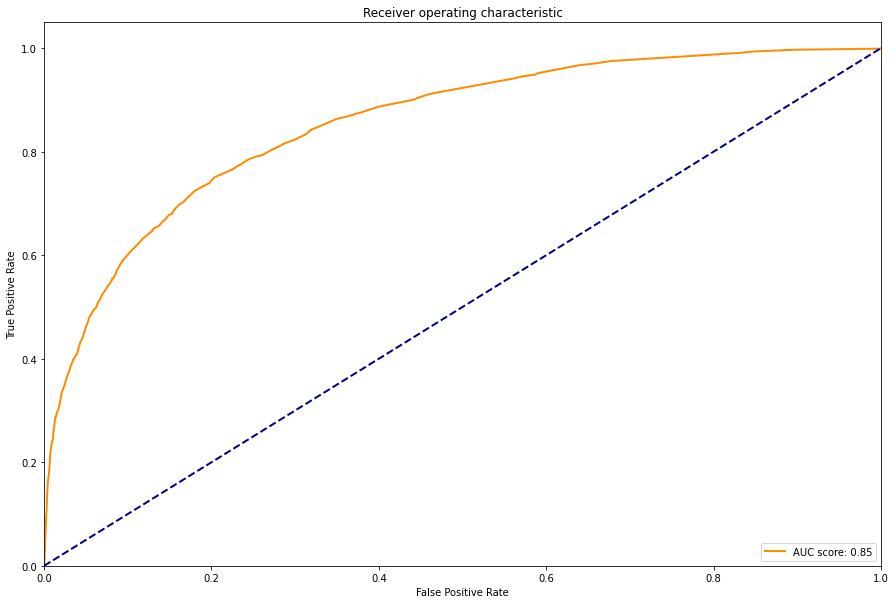

AUC-ROC para este modelo es: 0.8538810918643396


In [15]:
graficar_auc_roc(y_test_binario, y_pred_proba)

Podemos interpretar de la curva resultante, que si bien no logra encerrar un área mayor para llegar al score 1.0, el puntaje es lo suficientemente satisfactorio para un árbol de decisión. Del puntaje resultante estimamos que por lo general el árbol será capaz de realizar una separación correcta entre las clases. Para tener mejor previstas posibles falencias del modelo, graficaremos la matriz de confusión.

### Matriz de confusion

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


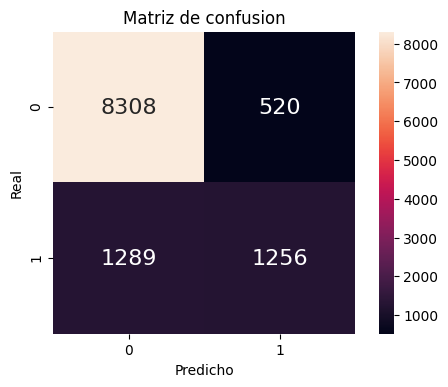

In [16]:
graficar_matriz_confusion(y_test_binario, y_pred_binario)

Podemos notar que si desprendemos los cálculos de Precision/Recall de la matriz resultante, estos coinciden con los reportados por classification_report(), y por lo tanto la confección de la misma es correcta. En general, las métricas observadas son de esperarse para un árbol de decisión, pues si bien son simples de comprender no siempre resultan en las mejores predicciones. Por ejemplo, el recall se mantiene en este caso por debajo de 0.5, lo cuál indica que le está siendo difícil al árbol atrapar todos los casos positivos.

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con el árbol sobre el dataset de predicciones nuevo, y escribimos los resultados al archivo 'ArbolDeDecision.csv'

In [17]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final, imputer_entrenado_1 = preprocesamiento_1(df_prediccion_final, imputer_entrenado_1)
predicciones = arbol_holdout.predict(df_prediccion_final.to_numpy())

exportar_prediccion_final(ids, predicciones, 'arbol_de_decision')